We will conduct sentiment analysis to categorise the opinions of people on Twitter toward the issue of the relocation of Indonesia's capital city. We will use a two-point ordinal scale of Positive and Negative to categorise the tweets.

## 01 | Getting Started

### Setting Up

We start by importing required libraries.

In [342]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import emoji
import string
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# ML libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Global parameters
stop_words = set(stopwords.words('indonesian'))

### Loading the dataset

The dataset contain 1,432 tweets already encoded into two categories by hand: 0 = Negative and 1 = Positive.

In [343]:
# Loading the dataset
def load_dataset(filename, cols):
    dataset = pd.read_csv(filename, encoding = 'utf-8')
    dataset.columns = cols
    return dataset

In [344]:
# Remove unwanted columns
def remove_unwanted_cols(dataset, cols):
    for col in cols:
        del dataset[col]
    return dataset

### Pre-processing

We do pre-processing for the tweets data including letter casing, normalization, stemming, lemmatization, etc.

#### Treating emoji and multi-words hashtags

As there are many multi-words hashtags and emojis in thetext  data, we create a function to convert the hashtags into words and remove the emojis.

In [345]:
# Create function to process multi-word hashtags
def process_hashtag(input_text: str) -> str:
    return re.sub(
        r'#[a-zA-Z]\S*',
        lambda m: ' '.join(re.findall('[A-Z][^A-Z]*|[a-z][^A-Z]*',
                                     m.group().lstrip('#'))), input_text,
    )

In [346]:
process_hashtag('Apa #JokowiTurunPDIPBubar')

'Apa Jokowi Turun P D I P Bubar'

In [347]:
# Create function to process emoji
def process_emoji(text):
    #return emoji.get_emoji_regexp().sub(r'', text)
    return emoji.replace_emoji(text, replace='')

In [348]:
process_emoji("Hi 🤔 How is your 🙈 and 😌. Have a nice weekend 💕👭👙")

'Hi  How is your  and . Have a nice weekend '

#### Process tweets

In [349]:
# Create function to clean tweets
def process_tweet(tweet):
    
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags = re.MULTILINE)
    # Remove user @ references
    tweet = re.sub(r"\@\w+", '', tweet)
    # Process hashtag
    tweet = process_hashtag(tweet)
    # Remove 1-length character
    tweet = re.sub(r"\b\w{1}\b", '', tweet)
    # Process emoji
    tweet = process_emoji(tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove additional white spaces
    tweet = re.sub(r"[\s]+", ' ', tweet)
    # Remove abbreviations
    tweet = re.sub(r"\b([b-df-hj-np-tv-z]){2,}\b|\b(amp)\b", '', tweet)
    # Trim
    tweet = tweet.strip('\'"')
    # Remove duplicate consecutive words
    tweet = re.sub(r"\b(\w+)\s\1\b", r"\1", tweet)
    # Make lowercase
    tweet = tweet.lower()
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)  
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    return " ".join(filtered_words)

#### Vectorize tweets

Vectorizing is the process to convert tokens to numbers. We will implement vectorization using tf-idf.

In [350]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf = True)
    vector.fit(train_fit)
    return vector

The target column is comprised of the integer value 0 and 1. We will convert the integer results to be easily understood by users.

In [351]:
def int_to_string(target):
    if target == 0:
        return "Negative"
    else:
        return "Positive"

## 02 | Data Preparation

### Load the dataset

In [352]:
# Load the dataset
dataset = load_dataset("data/twitterIKN-labelled.csv", ['author id', 'date', 'created_at', 'geo', 'id',
                                                       'lang', 'like_count', 'quote_count', 'reply_count',
                                                       'retweet_count', 'source', 'tweet', 'target'])

# Remove unwanted column from dataset
df = remove_unwanted_cols(dataset, ['author id', 'date', 'created_at', 'geo', 'id',
                                      'lang', 'like_count', 'quote_count', 'reply_count',
                                      'retweet_count', 'source'])

df.head()

,tweet,target
0,"PADAMU OLIGARKI, KAMI MENGABDI\n\nIKN memang b...",0
1,Sesekali mbok yo Jokowi yg dihadirkan untuk de...,0
2,Salah satu BONEKA OLIGARKI jadi calon pemimpin...,0
3,Sesungguhnya kebangkitan PKI itu nyata. Mengab...,0
4,Sejak era @SBYudhoyono bbrp kali saya cuit kon...,0


### Processing tweets

In [354]:
# Process data
df['tweet'] = df['tweet'].apply(process_tweet)
df['tweet'][72]

'rakyat sengsara uu ikn ayo tolak uu ikn v9uq'

### Overview of the positive and negative tweets

In [355]:
# Separate positive and negative tweets
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

print('Number of negative tweets: ', len(df_0))
print('Number of positive tweets: ', len(df_1))

Number of negative tweets:  861
Number of positive tweets:  866


In [378]:
#861 + 866 = 1727

# 80%: 1382
# 20%: 1727- 1382 = 345 

345

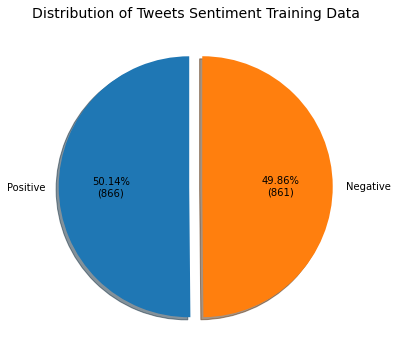

In [356]:
# Pie chart distribution of positive and negative tweets
def my_fmt(x):
    #print(x)
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

values = pd.Series(df['target'])
v_counts = values.value_counts()
total = len(values)
labs = ['Positive', 'Negative']

pie, ax_pie = plt.subplots(figsize = [10, 6])
plt.pie(v_counts, labels = labs, autopct = my_fmt,
        shadow=True, startangle=90, explode = [0.05, 0.05])
plt.title("Distribution of Tweets Sentiment Training Data", fontsize = 14)
plt.show()

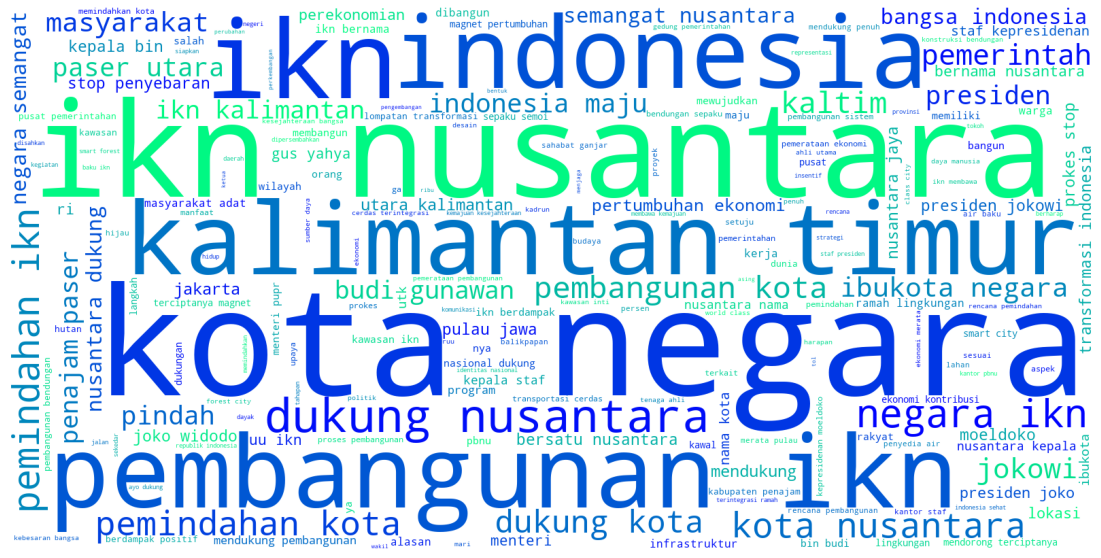

In [381]:
# Wordcloud positive
wordcloud_positive = WordCloud(background_color = "white", width = 1600, colormap='winter',
                               height = 800).generate(' '.join(df_1['tweet'].tolist()))
plt.figure(figsize = (20, 10), facecolor = 'w')
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.show()

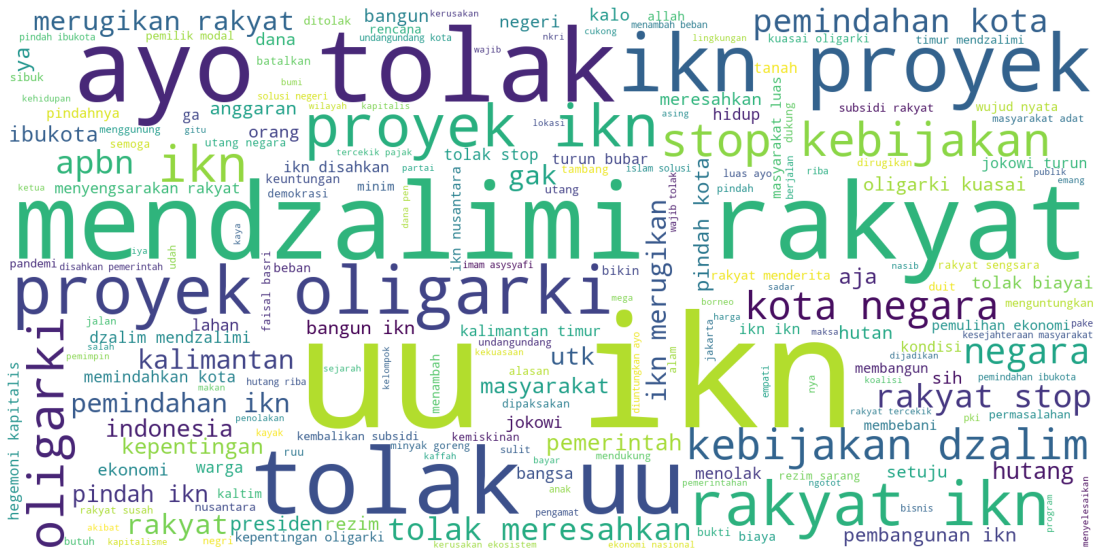

In [388]:
# Wordcloud negative
wordcloud_negative = WordCloud(background_color = "white", width = 1600,
                               height = 800).generate(' '.join(df_0['tweet'].tolist()))
plt.figure(figsize = (20, 10), facecolor = 'w')
plt.imshow(wordcloud_negative)
plt.axis("off")
plt.show()

### Split training and test data

In [361]:
# Split the dataset into train and test data
# Same tf vector will be used for testing sentiment on unseen trending data
tf_vector = get_feature_vector(np.array(df.iloc[:, 0]).ravel())

X = tf_vector.transform(np.array(df.iloc[:, 0]).ravel())
y = np.array(df.iloc[:, 1]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30)

## 03 | Model Training

### Naive Bayes

In [362]:
# Training Naive Bayes Model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)

print("Accuracy score: ", accuracy_score(y_test, y_predict_nb))

Accuracy score:  0.9450867052023122


In [401]:
# Precision, Recall, and F1-Score Report
print(classification_report(y_test, y_predict_nb, digits = 4,
                           target_names = ['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive     0.9615    0.9202    0.9404       163
    Negative     0.9316    0.9672    0.9491       183

    accuracy                         0.9451       346
   macro avg     0.9466    0.9437    0.9448       346
weighted avg     0.9457    0.9451    0.9450       346



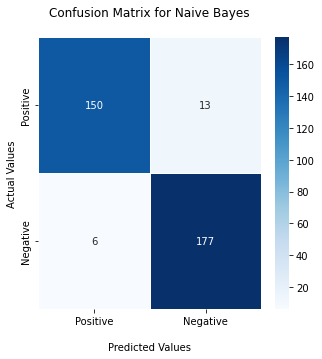

In [395]:
# Confusion metrics NB
NB_cm = confusion_matrix(y_test, y_predict_nb)

plt.figure(figsize = (5, 5))
NB_ax = sns.heatmap(NB_cm, cmap = 'Blues',
                    linecolor = 'white',
                    linewidth = 1,
                    annot = True,
                    fmt = '',
                    xticklabels = ['Positive', 'Negative'],
                    yticklabels = ['Positive', 'Negative'])
NB_ax.set_title("Confusion Matrix for Naive Bayes\n")
NB_ax.set_xlabel("\nPredicted Values")
NB_ax.set_ylabel("Actual Values")
plt.show()

#### Logistic Regression

In [365]:
LR_model = LogisticRegression(solver = 'lbfgs')
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_predict_lr))

Accuracy score:  0.9335260115606936


In [402]:
# Precision, Recall, and F1-Score Report
print(classification_report(y_test, y_predict_lr, digits = 4,
                           target_names = ['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive     0.9167    0.9448    0.9305       163
    Negative     0.9494    0.9235    0.9363       183

    accuracy                         0.9335       346
   macro avg     0.9331    0.9341    0.9334       346
weighted avg     0.9340    0.9335    0.9336       346



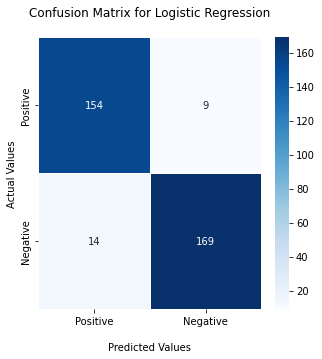

In [396]:
# Confusion metrics NB
LR_cm = confusion_matrix(y_test, y_predict_lr)

plt.figure(figsize = (5, 5))
LR_ax = sns.heatmap(LR_cm, cmap = 'Blues',
                    linecolor = 'white',
                    linewidth = 1,
                    annot = True,
                    fmt = '',
                    xticklabels = ['Positive', 'Negative'],
                    yticklabels = ['Positive', 'Negative'])
LR_ax.set_title("Confusion Matrix for Logistic Regression\n")
LR_ax.set_xlabel("\nPredicted Values")
LR_ax.set_ylabel("Actual Values")
plt.show()

#### Support Vector Machine

In [368]:
SVM_model = SVC(probability = True)
SVM_model.fit(X_train, y_train)
y_predict_svm = SVM_model.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_predict_svm))

Accuracy score:  0.9364161849710982


In [404]:
# Precision, Recall, and F1-Score Report
print(classification_report(y_test, y_predict_svm, digits = 4,
                           target_names = ['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive     0.9029    0.9693    0.9349       163
    Negative     0.9708    0.9071    0.9379       183

    accuracy                         0.9364       346
   macro avg     0.9368    0.9382    0.9364       346
weighted avg     0.9388    0.9364    0.9365       346



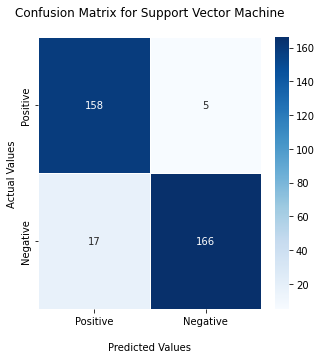

In [397]:
# Confusion metrics NB
SVM_cm = confusion_matrix(y_test, y_predict_svm)

plt.figure(figsize = (5, 5))
SVM_ax = sns.heatmap(SVM_cm, cmap = 'Blues',
                    linecolor = 'white',
                    linewidth = 1,
                    annot = True,
                    fmt = '',
                    xticklabels = ['Positive', 'Negative'],
                    yticklabels = ['Positive', 'Negative'])
SVM_ax.set_title("Confusion Matrix for Support Vector Machine\n")
SVM_ax.set_xlabel("\nPredicted Values")
SVM_ax.set_ylabel("Actual Values")
plt.show()

#### K-Nearest Neighbors

In [371]:
KNN_model = KNeighborsClassifier(n_neighbors = 7)
KNN_model.fit(X_train, y_train)
y_predict_knn = KNN_model.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_predict_knn))

Accuracy score:  0.9046242774566474


In [405]:
# Precision, Recall, and F1-Score Report
print(classification_report(y_test, y_predict_knn, digits = 4,
                           target_names = ['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive     0.9062    0.8896    0.8978       163
    Negative     0.9032    0.9180    0.9106       183

    accuracy                         0.9046       346
   macro avg     0.9047    0.9038    0.9042       346
weighted avg     0.9047    0.9046    0.9046       346



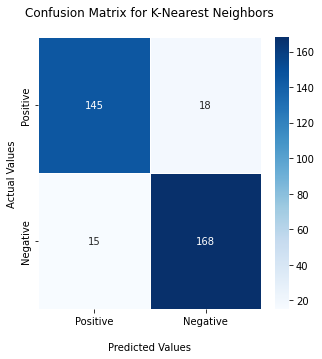

In [398]:
# Confusion metrics NB
KNN_cm = confusion_matrix(y_test, y_predict_knn)

plt.figure(figsize = (5, 5))
KNN_ax = sns.heatmap(KNN_cm, cmap = 'Blues',
                    linecolor = 'white',
                    linewidth = 1,
                    annot = True,
                    fmt = '',
                    xticklabels = ['Positive', 'Negative'],
                    yticklabels = ['Positive', 'Negative'])
KNN_ax.set_title("Confusion Matrix for K-Nearest Neighbors\n")
KNN_ax.set_xlabel("\nPredicted Values")
KNN_ax.set_ylabel("Actual Values")
plt.show()